# Figure Plotter

In this notebook, we will plot some new pdf figure to input in our report. The following section is the illustrator of our figures.

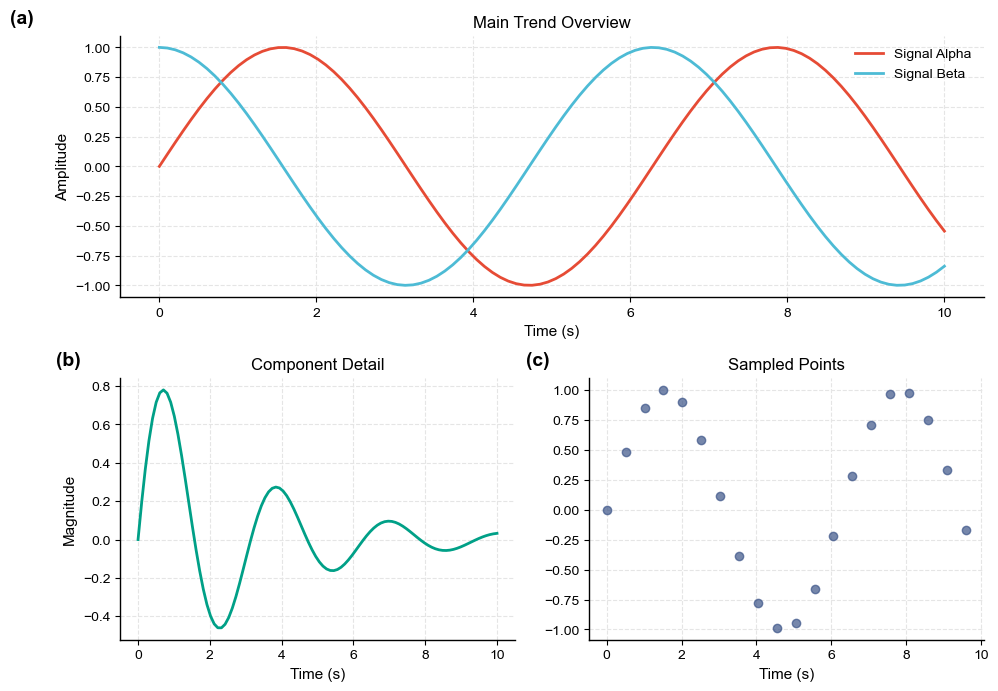

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 第一部分：应用全局报告样式 (让你告别丑陋的默认图)
# ==========================================
report_style = {
    "pdf.fonttype": 42, "ps.fonttype": 42, "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"], 
    "font.size": 10, "axes.titlesize": 12, "axes.labelsize": 11,
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 1.0, "axes.axisbelow": True,
    "axes.grid": True, "grid.color": "#E5E5E5", "grid.linestyle": "--",
    "legend.frameon": False,
    # 经典 Science/Nature 高级配色
    "axes.prop_cycle": plt.cycler('color', ['#E64B35', '#4DBBD5', '#00A087', '#3C5488']),
    "lines.linewidth": 2.0, "figure.autolayout": True, 
    "savefig.bbox": "tight", "savefig.transparent": True
}
plt.rcParams.update(report_style)

# ==========================================
# 第二部分：生成一些模拟数据
# ==========================================
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.exp(-x/3) * np.sin(2*x)

# ==========================================
# 第三部分：使用 subplot_mosaic 魔法进行拼图！
# ==========================================
# 用字母直观地“画”出你的排版：
# 第一行全是 'A' (跨两列)
# 第二行左边是 'B'，右边是 'C'
layout = """
    AA
    BC
"""

# figsize 控制整张拼图画布的物理尺寸 (宽, 高)，单位是英寸
fig, axes = plt.subplot_mosaic(layout, figsize=(10, 7))

# -----------------
# 填充图 A (主图)
# -----------------
# axes['A'] 就代表拿到了布局里 A 的那块地盘
axes['A'].plot(x, y1, label='Signal Alpha')
axes['A'].plot(x, y2, label='Signal Beta')
axes['A'].set_title('Main Trend Overview')
axes['A'].set_xlabel('Time (s)')
axes['A'].set_ylabel('Amplitude')
axes['A'].legend()

# -----------------
# 填充图 B (左下图)
# -----------------
axes['B'].plot(x, y3, color='#00A087', label='Decay Component') # 可以单独指定颜色
axes['B'].set_title('Component Detail')
axes['B'].set_xlabel('Time (s)')
axes['B'].set_ylabel('Magnitude')

# -----------------
# 填充图 C (右下图：假设是个散点图)
# -----------------
axes['C'].scatter(x[::5], y1[::5], color='#3C5488', alpha=0.7)
axes['C'].set_title('Sampled Points')
axes['C'].set_xlabel('Time (s)')

# ==========================================
# 第四部分：一键导出无损 PDF
# ==========================================
# 为报告或论文加上 a, b, c 的小标（学术圈非常需要这个）
for label, ax in axes.items():
    # 在每个子图的左上角标上 (a), (b), (c)
    ax.text(-0.1, 1.1, f'({label.lower()})', transform=ax.transAxes, 
            fontsize=14, fontweight='bold', va='top', ha='right')

# plt.savefig('final_report_plot.pdf')
plt.show() # 如果你想在跑代码时顺便预览一下，可以取消注释这行

The first plot will demonstrate the region of Salish Sea and the range of our numerical model.

## Methods


完成！带框图例 + 倾斜文字的终极图已保存至: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_pdf/Map_New.pdf


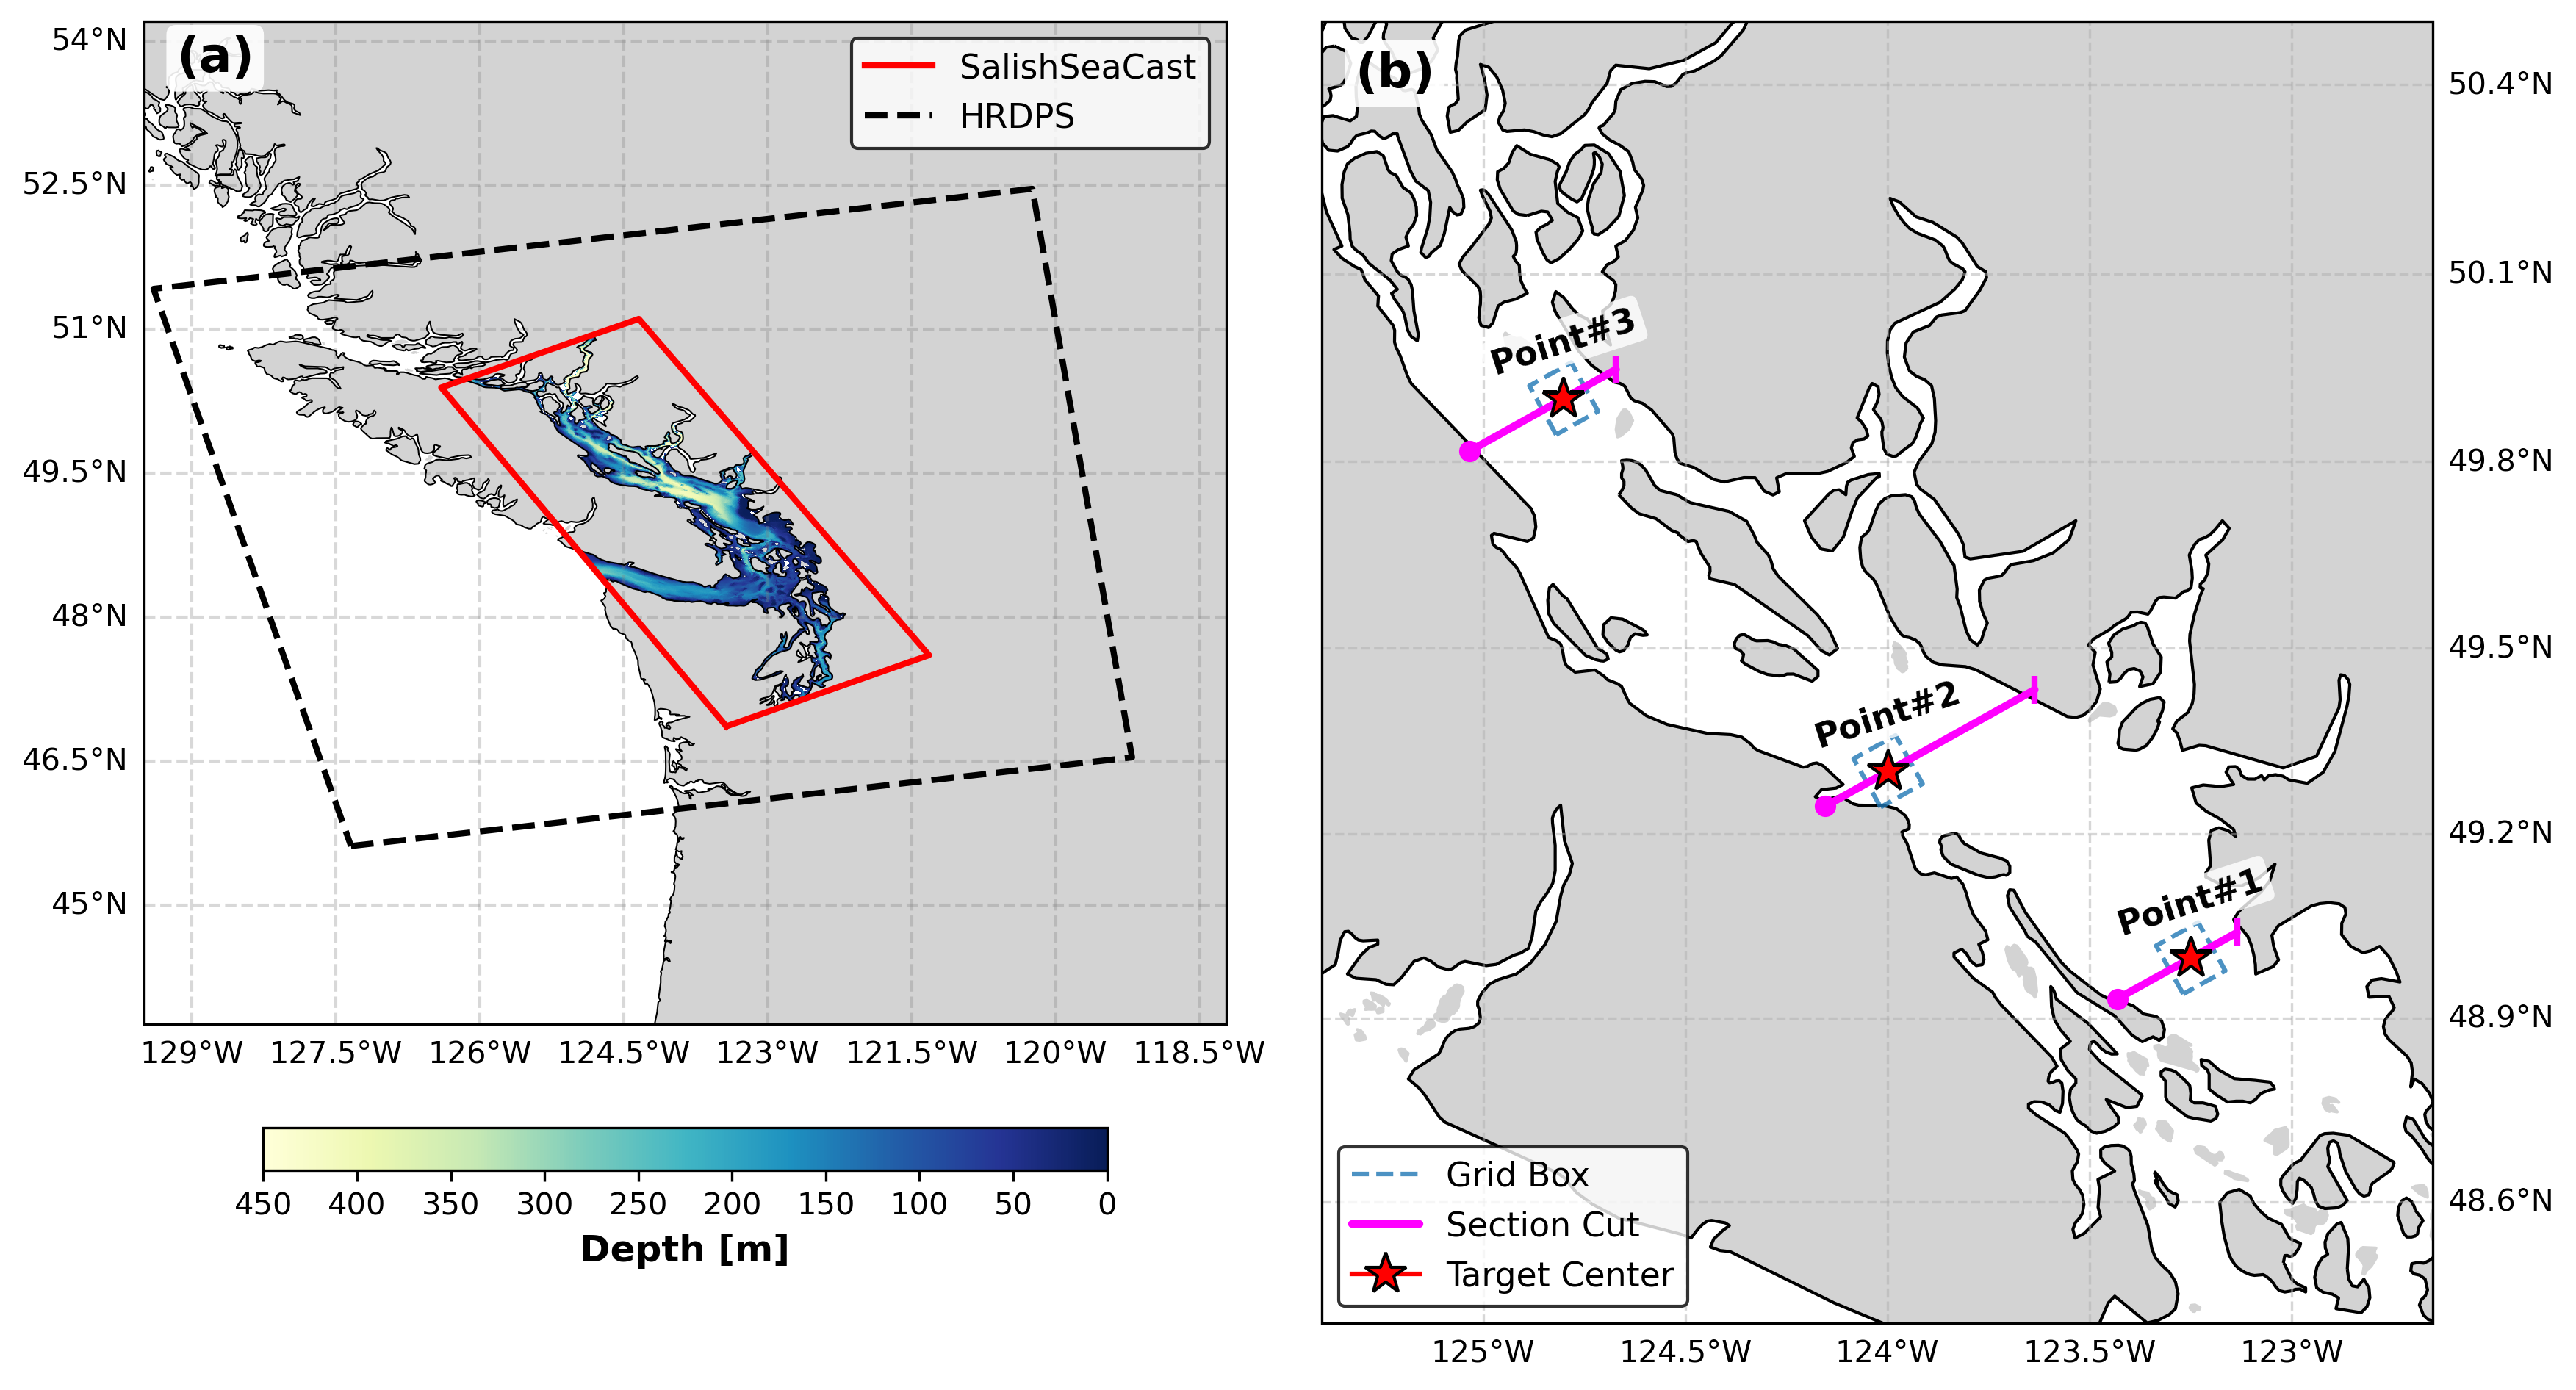

In [5]:
# Region Show

import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER



# ==========================================
# 1. 配置文件与路径 (请根据你的实际路径调整)
# ==========================================

BATHY_FILE = "/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc"
WIND_FILE = "/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2007m01d03.nc"

BASE_DIR = '/results2/SalishSea/nowcast-green.201905/'
SAMPLE_FILE_PATH = os.path.join(BASE_DIR, '01jun18/SalishSea_1d_20180601_20180601_grid_T.nc')
OUTPUT_DIR = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_pdf/'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TARGETS_DEFINITIONS = {
    'Point_1': {'value': (49.0, -123.25), 'label': 'Point#1'},
    'Point_2': {'value': (49.3, -124.0),  'label': 'Point#2'},
    'Point_3': {'value': (49.9, -124.8),  'label': 'Point#3'},
}

STATIONS_DEFINITIONS = {
    #'SH': {'lat': 49.11, 'lon': -123.3, 'label': 'Sandheads',  'color': 'gold'}
}

GRID_BOX_RADIUS = 10 
SECTION_CONFIG = {
    'Point_1': {'left_offset': 35, 'right_offset': 22},
    'Point_2': {'left_offset': 30, 'right_offset': 70}, 
    'Point_3': {'left_offset': 45, 'right_offset': 25},
}

VAR_LAT = 'nav_lat'
VAR_LON = 'nav_lon'

# ==========================================
# 2. 辅助函数合集
# ==========================================

def get_valid_boundary(lon_grid, lat_grid):
    valid_mask = (np.abs(lon_grid) > 1e-3) & (np.abs(lat_grid) > 1e-3)
    rows, cols = np.where(valid_mask)
    if len(rows) == 0:
        raise ValueError("Grid contains only zeros or invalid coordinates!")
    min_row, max_row = rows.min(), rows.max()
    min_col, max_col = cols.min(), cols.max()
    corners_idx = [
        (min_row, min_col), (min_row, max_col), 
        (max_row, max_col), (max_row, min_col), (min_row, min_col)
    ]
    return [lon_grid[r, c] for r, c in corners_idx], [lat_grid[r, c] for r, c in corners_idx]

def load_grid(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Grid file not found: {file_path}")
    with nc.Dataset(file_path, 'r') as ds:
        return ds.variables[VAR_LAT][:], ds.variables[VAR_LON][:]

def find_nearest_index(lat_2d, lon_2d, target_lat, target_lon):
    dist_sq = (lat_2d - target_lat)**2 + (lon_2d - target_lon)**2
    min_idx_flat = dist_sq.argmin()
    return np.unravel_index(min_idx_flat, lat_2d.shape)

def get_parallelogram_coords(lat_2d, lon_2d, cy, cx, radius):
    ny, nx = lat_2d.shape
    y_min, y_max = max(0, cy - radius), min(ny - 1, cy + radius)
    x_min, x_max = max(0, cx - radius), min(nx - 1, cx + radius)
    lats = [lat_2d[y_min, x_min], lat_2d[y_max, x_min], lat_2d[y_max, x_max], lat_2d[y_min, x_max], lat_2d[y_min, x_min]]
    lons = [lon_2d[y_min, x_min], lon_2d[y_max, x_min], lon_2d[y_max, x_max], lon_2d[y_min, x_max], lon_2d[y_min, x_min]]
    return lons, lats

def get_section_line_coords(lat_2d, lon_2d, cy, cx, config):
    ny, nx = lat_2d.shape
    x_start = max(0, cx - config['left_offset'])
    x_end = min(nx - 1, cx + config['right_offset'])
    return lon_2d[cy, x_start:x_end+1], lat_2d[cy, x_start:x_end+1], (cy, x_start), (cy, x_end)

# ==========================================
# 3. 主程序 - 绘图缝合 (A4 紧凑优化版)
# ==========================================
def main():
    with nc.Dataset(BATHY_FILE, 'r') as ds:
        ss_lons, ss_lats = ds.variables['nav_lon'][:], ds.variables['nav_lat'][:]
        bathy = ds.variables['Bathymetry'][:]
    with nc.Dataset(WIND_FILE, 'r') as ds:
        wind_lons, wind_lats = ds.variables['nav_lon'][:], ds.variables['nav_lat'][:]
    
    ss_bound_x, ss_bound_y = get_valid_boundary(ss_lons, ss_lats)
    wind_bound_x, wind_bound_y = get_valid_boundary(wind_lons, wind_lats)

    lat_2d, lon_2d = load_grid(SAMPLE_FILE_PATH)
    results = {}
    for key, info in TARGETS_DEFINITIONS.items():
        t_lat, t_lon = info['value']
        y_idx, x_idx = find_nearest_index(lat_2d, lon_2d, t_lat, t_lon)
        box_lons, box_lats = get_parallelogram_coords(lat_2d, lon_2d, y_idx, x_idx, GRID_BOX_RADIUS)
        sec_config = SECTION_CONFIG.get(key, {'left_offset': 20, 'right_offset': 20})
        sec_lons, sec_lats, _, _ = get_section_line_coords(lat_2d, lon_2d, y_idx, x_idx, sec_config)
        results[key] = {
            'label': info['label'], 'y_idx': y_idx, 'x_idx': x_idx,
            'center_coords': (lat_2d[y_idx, x_idx], lon_2d[y_idx, x_idx]),
            'box_coords': (box_lons, box_lats), 'section_coords': (sec_lons, sec_lats)
        }

    fig = plt.figure(figsize=(12, 6.5), dpi=300)

    # ---------------------------------------------------------
    # 子图 (a): 宏观边界与深度图
    # ---------------------------------------------------------
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
    
    pcm = ax1.pcolormesh(ss_lons, ss_lats, bathy, transform=ccrs.PlateCarree(),
                         cmap='YlGnBu_r', vmin=0, vmax=450, rasterized=True) 
    ax1.add_feature(cfeature.LAND, facecolor='#d3d3d3', edgecolor='none', zorder=2)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=3)

    ax1.plot(ss_bound_x, ss_bound_y, transform=ccrs.PlateCarree(), 
             color='red', linewidth=2, linestyle='-', zorder=10, label='SalishSeaCast')
    ax1.plot(wind_bound_x, wind_bound_y, transform=ccrs.PlateCarree(), 
             color='black', linewidth=2, linestyle='--', zorder=10, label='HRDPS')

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False 
    gl1.xformatter = LONGITUDE_FORMATTER
    gl1.yformatter = LATITUDE_FORMATTER
    gl1.xlabel_style = {'size': 10}
    gl1.ylabel_style = {'size': 10}

    # 【修改点 1】: 强制显示半透明白框，加上黑边
    ax1.legend(loc='upper right', fontsize=11, frameon=True, facecolor='white', edgecolor='black', framealpha=0.8)
    
    cbar = plt.colorbar(pcm, ax=ax1, orientation='horizontal', pad=0.08, shrink=0.75)
    cbar.ax.invert_xaxis()
    cbar.set_label('Depth [m]', fontsize=12, fontweight='bold')

    buff = 3.1 
    ax1.set_extent([np.min(ss_lons) - buff, np.max(ss_lons) + buff,
                    np.min(ss_lats) - buff, np.max(ss_lats) + buff])
    
    ax1.text(0.03, 0.95, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'), zorder=20)

    # ---------------------------------------------------------
    # 子图 (b): 微观目标点与网格切片
    # ---------------------------------------------------------
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Mercator(central_longitude=-124))
    
    all_lons = [pt['value'][1] for pt in TARGETS_DEFINITIONS.values()]
    all_lats = [pt['value'][0] for pt in TARGETS_DEFINITIONS.values()]
    margin = 0.6
    ax2.set_extent([min(all_lons)-margin, max(all_lons)+margin, 
                    min(all_lats)-margin, max(all_lats)+margin], crs=ccrs.PlateCarree())

    ax2.add_feature(cfeature.LAND, color='lightgray', zorder=1)
    ax2.add_feature(cfeature.COASTLINE, linewidth=1, zorder=2)
    gl2 = ax2.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gl2.top_labels = False
    gl2.left_labels = False 
    gl2.xlabel_style = {'size': 10}
    gl2.ylabel_style = {'size': 10}

    for i, (key, res) in enumerate(results.items()):
        color = '#1f77b4'
        box_lons, box_lats = res['box_coords']
        ax2.plot(box_lons, box_lats, transform=ccrs.PlateCarree(), 
                 color=color, linestyle='--', linewidth=1.5, alpha=0.8, label=f"Grid Box" if i==0 else "")
        
        sec_lons, sec_lats = res['section_coords']
        ax2.plot(sec_lons, sec_lats, transform=ccrs.PlateCarree(), color='magenta', linewidth=2.5, solid_capstyle='round', zorder=5, label=f"Section Cut" if i==0 else "")
        ax2.plot(sec_lons[0], sec_lats[0], transform=ccrs.PlateCarree(), marker='o', color='magenta', markersize=6, zorder=6)
        ax2.plot(sec_lons[-1], sec_lats[-1], transform=ccrs.PlateCarree(), marker='|', color='magenta', markersize=9, markeredgewidth=2, zorder=6)

        cy_lat, cx_lon = res['center_coords']
        ax2.plot(cx_lon, cy_lat, transform=ccrs.PlateCarree(), marker='*', color='red', markersize=14, zorder=10, markeredgecolor='black', label='Target Center' if i==0 else "")
        
        # 顺手把 Point 文字也往上提了一点点 (+0.04)
        ax2.text(cx_lon, cy_lat + 0.04, res['label'], transform=ccrs.PlateCarree(), 
                 horizontalalignment='center', fontsize=11, fontweight='bold', rotation=18,bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'),zorder=10)
        
    for s_id, s_info in STATIONS_DEFINITIONS.items():
        s_lon, s_lat, s_label, s_color = s_info['lon'], s_info['lat'], s_info['label'], s_info.get('color', 'black')
        ax2.plot(s_lon, s_lat, transform=ccrs.PlateCarree(), marker='^', color=s_color, markersize=11, markeredgecolor='black', zorder=15, linestyle='None', label=f"Station: {s_label}")
        
        # 【修改点 2】: 站点文字上提 (s_lat+0.06)，向左微调 (s_lon-0.12)，并旋转15度 (rotation=15)
        ax2.text(s_lon-0.2, s_lat+0.02, s_label, transform=ccrs.PlateCarree(), 
                 fontsize=11, fontweight='bold', color='black', verticalalignment='bottom', 
                 rotation=18, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'),zorder=15)

    # 【修改点 1】: 右图的图例也加上半透明白框
    ax2.legend(loc='lower left', fontsize=11, frameon=True, facecolor='white', edgecolor='black', framealpha=0.8)

    ax2.text(0.03, 0.95, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'), zorder=20)

    plt.tight_layout(pad=1.5, w_pad=1.0) 
    
    out_file = os.path.join(OUTPUT_DIR, "Map_New.pdf")
    plt.savefig(out_file, format='pdf', bbox_inches='tight', dpi=300)
    print(f"完成！带框图例 + 倾斜文字的终极图已保存至: {out_file}")
    plt.show()

if __name__ == "__main__":
    main()

Figure 1. Overview of the study area, modeling domains, and specific target locations. (a) The spatial extents of the high-resolution SalishSeaCast bio-physical ocean model (red solid line) and the High-Resolution Deterministic Prediction System (HRDPS) atmospheric forcing model (black dashed line). The background color shading represents the bathymetry (depth in meters) within the SalishSeaCast domain. (b) A detailed view of the Strait of Georgia showing the selected sampling sites. Red stars indicate the three target centers (Point#1, Point#2, and Point#3) positioned in the southern, central, and northern regions of the strait, respectively. Magenta solid lines represent the corresponding cross-strait transects (evaluating the upper 50 m of the water column) designed to capture cross-basin asymmetries and upwelling events. The dashed blue boxes denote the surrounding grid extraction areas for each target point. The yellow triangle indicates the location of the Sandheads meteorological observation station.


### Modeling Framework and Forcing Data

The physical and biogeochemical dynamics of the region were simulated using the SalishSeaCast model, a three-dimensional coupled bio-physical ocean model with a high horizontal resolution of approximately 500 m. The spatial domain and bathymetry of the SalishSeaCast model are delineated in Figure 1a (red box). Surface atmospheric forcing for the ocean model was provided by the High-Resolution Deterministic Prediction System (HRDPS), which operates at a 2.5 km resolution. As shown in Figure 1a, the HRDPS wind model domain (black dashed box) entirely encompasses the SalishSeaCast domain.

Riverine input, a critical driver of the Salish Sea's estuarine circulation, was also incorporated. Specifically, discharge from the Fraser River was distributed among its three main arms based on regional mapping (BCCF and WA maps) and historical literature (Thomson, 1981). In the model's watershed configuration, the Fraser River is assumed to contribute 98% of the regional freshwater discharge, while the remaining 2% is attributed to smaller U.S. rivers to the south (WRIA 1).

### Data Extraction and Study Sites

Model outputs were extracted over a 10-year period from 2010 to 2019. While the native model output possesses an hourly temporal resolution, the data were subjected to various temporal averagings (e.g., daily or monthly means) to facilitate the analysis and visualization of long-term trends. The primary variables extracted for this study included physical parameters (temperature and salinity) and biological parameters (diatom and flagellate concentrations). To provide empirical context and validate the local atmospheric forcing, continuous observational wind field data from the Sandheads station (Figure 1b) were utilized.

To investigate spatial variations and vertical dynamics within the strait, three specific target points and corresponding cross-strait transects were selected (Figure 1b). These transects are strategically distributed along the longitudinal axis of the Strait of Georgia, representing the northern (Point#3), central (Point#2), and southern (Point#1) regions. Furthermore, to capture cross-basin asymmetries, the target centers were explicitly positioned on the western side, central channel, and eastern side of the strait, respectively. The cross-strait transects (magenta lines) were established across these points to analyze the upper 50 m of the water column, a depth range chosen to effectively capture stratification variations and detect wind-driven coastal upwelling events.

### Storm Event Definition and Time Series Processing
The analysis focused on a prolonged summer storm event spanning 9 days, from July 9 to July 17. Given the exceptionally long duration of this specific forcing event, the primary ecological response was assessed directly on the final day of the storm (July 17), rather than waiting for a post-storm relaxation period.

The biological data were output at 6-hourly intervals. To eliminate the interference of high-frequency diurnal cycles and isolate the macro-scale trends driven by the meteorological forcing, a 24-hour moving average (a 4-step rolling window applied to the 6-hourly data) was implemented on the final time-series.

--- Fetching Data ---
Processing 2011...
Processing 2018...
--- Plotting ---
Plot saved to: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_pdf/Combined_Report_Figures.pdf


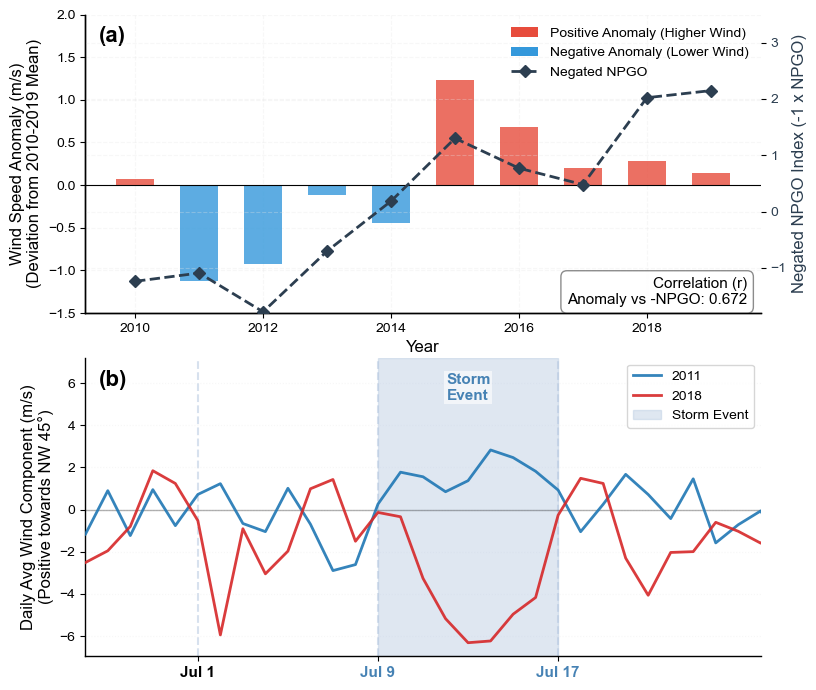

In [ ]:
# Time Selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import netCDF4 as nc
import datetime
import os

# ================= 配置区域 (合并) =================
# --- 图 a: NPGO vs Wind ---
DIR_WIND = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Data_SandHead'
FILE_NPGO = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Data_NPGO/npgo.csv'
SUMMER_MONTHS = [5, 6, 7, 8]

# --- 图 b: Storm Wind Analysis ---
TARGET_LAT = 49.0
TARGET_LON = -123.25 
TARGET_LON_ADJUSTED = 360 + TARGET_LON 
GRID_BOX_RADIUS = 10 
PROJECTION_ANGLE_DEG = 315.0 
MONTHS = [6, 7, 8, 9] 
YEARS = [2011, 2018]

indir_data = {
    2011: '/results/forcing/atmospheric/GEM2.5/gemlam/',
    2018: '/results/forcing/atmospheric/GEM2.5/operational/',
}
fname_head = {
    2011: 'gemlam_',
    2018: 'ops_',
}
fname_tail = '.nc'

indir_results = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_pdf/'
if not os.path.exists(indir_results):
    os.makedirs(indir_results)

subregion_cache = {}
# ==================================================

# ----------------- 数据处理函数 (图 a) -----------------
def get_summer_wind_stats():
    all_data = []
    col_date = 'Date/Time'
    col_dir = 'Dir of Max Gust (10s deg)'
    col_spd = 'Spd of Max Gust (km/h)'
    axis_from_deg = 135 

    for year in range(2010, 2020):
        file_name = f'en_climate_daily_BC_1107010_{year}_P1D.csv'
        file_path = os.path.join(DIR_WIND, file_name)
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                df = df[[col_date, col_dir, col_spd]].copy()
                df[col_date] = pd.to_datetime(df[col_date])
                
                df = df[df[col_date].dt.month.isin(SUMMER_MONTHS)].copy()
                
                df[col_dir] = pd.to_numeric(df[col_dir], errors='coerce')
                df[col_spd] = pd.to_numeric(df[col_spd], errors='coerce')
                df.dropna(subset=[col_dir, col_spd], inplace=True)
                
                if not df.empty:
                    wind_dir_deg = df[col_dir] * 10
                    radians = np.deg2rad(wind_dir_deg - axis_from_deg)
                    # df['Abs_Proj_Speed'] = (df[col_spd] * np.cos(radians)).abs()
                    # 将 km/h 除以 3.6 转换为 m/s
                    df['Abs_Proj_Speed'] = (df[col_spd] / 3.6 * np.cos(radians)).abs()
                    summer_mean = df['Abs_Proj_Speed'].mean()
                    all_data.append({'Year': year, 'Wind_Summer_Mean': summer_mean})
            except Exception:
                pass
    
    if not all_data: return None
    
    df_res = pd.DataFrame(all_data).set_index('Year')
    climatology = df_res['Wind_Summer_Mean'].mean()
    df_res['Wind_Anomaly'] = df_res['Wind_Summer_Mean'] - climatology
    return df_res

def get_summer_npgo_negated():
    try:
        df = pd.read_csv(FILE_NPGO, skiprows=1, names=['Date', 'NPGO'], skipinitialspace=True)
        df['Date'] = pd.to_datetime(df['Date'])
        df['NPGO'] = pd.to_numeric(df['NPGO'], errors='coerce')
        df.loc[df['NPGO'] == -9999, 'NPGO'] = None
        df.dropna(inplace=True)
        
        df = df[df['Date'].dt.month.isin(SUMMER_MONTHS)].copy()
        df['Year'] = df['Date'].dt.year
        
        annual_npgo = df.groupby('Year')['NPGO'].mean()
        return annual_npgo * -1
    except Exception:
        return None

# ----------------- 数据处理函数 (图 b) -----------------
def find_grid_index(nc_file_path, lat_t, lon_t, radius):
    try:
        with nc.Dataset(nc_file_path, 'r') as ds:
            if 'nav_lat' in ds.variables:
                lats = ds.variables['nav_lat'][:]
                lons = ds.variables['nav_lon'][:]
            elif 'latitude' in ds.variables:
                lats = ds.variables['latitude'][:]
                lons = ds.variables['longitude'][:]
            else:
                return None, None, None, None

        sq_dist = (lons - lon_t)**2 + (lats - lat_t)**2
        j_target, i_target = np.unravel_index(sq_dist.argmin(), sq_dist.shape)
        
        j_start = max(0, j_target - radius)
        j_end = min(lats.shape[0], j_target + radius + 1)
        i_start = max(0, i_target - radius)
        i_end = min(lats.shape[1], i_target + radius + 1)
        return j_start, j_end, i_start, i_end
    except:
        return None, None, None, None

def get_daily_projected_wind(year, month_list, lat_t, lon_t, radius, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    sin_a = np.sin(angle_rad)
    cos_a = np.cos(angle_rad)
    
    days_axis = []
    daily_values = []
    
    path = indir_data[year]
    head = fname_head[year]
    
    sample_file = path + head + datetime.date(year, 6, 1).strftime('y%Ym%md%d') + fname_tail
    cache_key = (year, lat_t, lon_t)
    
    if cache_key in subregion_cache:
        j_s, j_e, i_s, i_e = subregion_cache[cache_key]
    else:
        if not os.path.exists(sample_file):
             sample_file = path + head + datetime.date(year, 6, 2).strftime('y%Ym%md%d') + fname_tail
        if os.path.exists(sample_file):
            j_s, j_e, i_s, i_e = find_grid_index(sample_file, lat_t, lon_t, radius)
            subregion_cache[cache_key] = (j_s, j_e, i_s, i_e)
        else:
            return [], []

    start_date = datetime.date(year, month_list[0], 1)
    end_date = datetime.date(year, month_list[-1], 30)
    current_date = start_date
    day_counter = 0 
    
    print(f"Processing {year}...")
    while current_date <= end_date:
        fpath = path + head + current_date.strftime('y%Ym%md%d') + fname_tail
        val_to_append = np.nan
        if os.path.exists(fpath) and j_s is not None:
            try:
                with nc.Dataset(fpath, 'r') as ds:
                    u_data = ds.variables['u_wind'][:, j_s:j_e, i_s:i_e]
                    v_data = ds.variables['v_wind'][:, j_s:j_e, i_s:i_e]
                    u_spatial = np.mean(u_data, axis=(1, 2))
                    v_spatial = np.mean(v_data, axis=(1, 2))
                    wind_proj = (u_spatial * sin_a) + (v_spatial * cos_a)
                    val_to_append = np.mean(wind_proj)
            except: pass
        
        days_axis.append(day_counter)
        daily_values.append(val_to_append)
        current_date += datetime.timedelta(days=1)
        day_counter += 1
        
    return days_axis, daily_values

# ----------------- 主程序及合并绘图 -----------------
def main():
    print("--- Fetching Data ---")
    # 获取图 a 数据
    wind_df = get_summer_wind_stats()
    npgo_series = get_summer_npgo_negated()
    
    # 获取图 b 数据
    data_storage = {}
    for yr in YEARS:
        days, values = get_daily_projected_wind(
            yr, MONTHS, TARGET_LAT, TARGET_LON_ADJUSTED, 
            GRID_BOX_RADIUS, PROJECTION_ANGLE_DEG
        )
        data_storage[yr] = (days, values)

    print("--- Plotting ---")
    # 创建 A4 适配画布
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.27, 7))

    # ==========================================
    # 绘制图 (a): NPGO vs Wind Speed Anomaly
    # ==========================================
    if wind_df is not None and npgo_series is not None:
        merged = wind_df.join(npgo_series, how='inner')
        merged.rename(columns={'NPGO': 'Neg_NPGO'}, inplace=True)
        corr = merged['Wind_Anomaly'].corr(merged['Neg_NPGO'])

        years = merged.index
        colors = ['#E74C3C' if x >= 0 else '#3498DB' for x in merged['Wind_Anomaly']]
        
        # 将柱状图的 zorder 设为 2，保证在网格之上
        ax1.bar(years, merged['Wind_Anomaly'], color=colors, alpha=0.8, width=0.6, zorder=2, label='Wind Speed Anomaly')
        ax1.set_xlabel('Year', fontsize=12)
        # ax1.set_ylabel('Wind Speed Anomaly (km/h)\n(Deviation from 2010-2019 Mean)', fontsize=12)
        ax1.set_ylabel('Wind Speed Anomaly (m/s)\n(Deviation from 2010-2019 Mean)', fontsize=12)
        ax1.axhline(0, color='black', linewidth=0.8, zorder=2)
        
        ax1_twin = ax1.twinx()
        # 将折线图的 zorder 设为 3，保证在最上层
        ax1_twin.plot(years, merged['Neg_NPGO'], color='#2C3E50', marker='D', markersize=6, linewidth=2, linestyle='--', label='Negated NPGO Index (-1)', zorder=3)
        ax1_twin.set_ylabel('Negated NPGO Index (-1 x NPGO)', fontsize=12, color='#2C3E50')
        ax1_twin.tick_params(axis='y', labelcolor='#2C3E50')
        
        legend_elements = [
            Patch(facecolor='#E74C3C', label='Positive Anomaly (Higher Wind)'),
            Patch(facecolor='#3498DB', label='Negative Anomaly (Lower Wind)'),
            plt.Line2D([0], [0], color='#2C3E50', linestyle='--', marker='D', label='Negated NPGO')
        ]
        ax1.legend(handles=legend_elements, loc='upper right', frameon=False)

        stats_text = f"Correlation (r)\nAnomaly vs -NPGO: {corr:.3f}"
        ax1.text(0.98, 0.02, stats_text, transform=ax1.transAxes, ha='right', va='bottom', fontsize=11, bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.9), zorder=4)

        # --- 修复 1 & 2：网格放底层 + 拔高天花板 ---
        ax1.grid(True, linestyle='--', alpha=0.3, zorder=0) # 开启网格并放到 zorder=0
        ax1.set_axisbelow(True)      # 强制 ax1 网格在底层
        ax1_twin.grid(True, linestyle='--', alpha=0.3, zorder=0) # 开启网格并放到 zorder=0
        ax1_twin.set_axisbelow(True) # 强制 ax1_twin 网格在底层
        
        # 拔高 Y 轴上限，给右上角图例留出空间
        ax1.set_ylim(-1.5, 2.0)       # 左侧风速距平范围扩大
        ax1_twin.set_ylim(-1.8, 3.5)  # 右侧 NPGO 范围扩大
        # ------------------------------------------

    ax1.text(0.02, 0.96, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'), zorder=20)

    # ==========================================
    # 绘制图 (b): Storm Wind Analysis
    # ==========================================
    colors_line = {2011: 'tab:blue', 2018: 'tab:red'}
    color_storm = 'lightsteelblue'
    
    for year in YEARS:
        days, values = data_storage[year]
        ax2.plot(days, values, label=f'{year}', color=colors_line[year], linewidth=2, alpha=0.9, zorder=3)

    storm_start, storm_end = 38, 46
    ax2.axvspan(storm_start, storm_end, color=color_storm, alpha=0.4, label='Storm Event', zorder=1)
    
    y_limits = ax2.get_ylim()
    text_y = y_limits[1] - (y_limits[1] - y_limits[0]) * 0.05 
    ax2.text((storm_start + storm_end)/2, text_y, 'Storm\nEvent', ha='center', va='top', fontsize=11, fontweight='bold', color='steelblue', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1), zorder=4)
    
    major_ticks = [30, 38, 46] 
    major_labels = ['Jul 1', 'Jul 9', 'Jul 17']
    ax2.set_xticks(major_ticks)
    ax2.set_xticklabels(major_labels, rotation=0, fontsize=11, fontweight='bold')
    
    for label in ax2.get_xticklabels():
        if label.get_text() in ['Jul 9', 'Jul 17']:
            label.set_color('steelblue')
        elif label.get_text() == 'Jul 1':
            label.set_color('black')     

    ax2.set_xlim(25, 55)
    
    # --- 修复 1：网格放底层 ---
    # 显式指定 zorder=0，并调用 set_axisbelow
    ax2.grid(True, which='major', axis='x', linestyle='--', color=color_storm, linewidth=1.5, alpha=0.5, zorder=0)
    ax2.grid(True, axis='y', linestyle=':', alpha=0.3, zorder=0)
    ax2.set_axisbelow(True)
    # --------------------------
    
    ax2.axhline(0, color='black', linewidth=1, alpha=0.3, zorder=2)
    
    ax2.set_ylabel('Daily Avg Wind Component (m/s)\n(Positive towards NW 45°)', fontsize=12)
    ax2.legend(loc='upper right', frameon=True) 
    
    ax2.text(0.02, 0.96, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'), zorder=20)

    # ==========================================
    # 最终排版与保存为 PDF
    # ==========================================
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.15) 
    
    save_path = os.path.join(indir_results, 'Time_Selection.pdf')
    plt.savefig(save_path, dpi=300, format='pdf', bbox_inches='tight')
    print(f"Plot saved to: {save_path}")
    plt.show()

if __name__ == "__main__":
    main()



Figure 2. Interannual climate variability and daily along-strait wind dynamics. (a) Summer (May–August) wind speed anomalies (bars) and the negated North Pacific Gyre Oscillation (-NPGO) index (dashed line) from 2010 to 2019. Red and blue bars represent positive (higher wind) and negative (lower wind) anomalies relative to the 10-year mean, respectively. The strong positive correlation (r = 0.672) between the wind anomaly and -NPGO is shown in the bottom right. (b) Daily average wind components projected along the NW 45° axis for the contrasting years of 2011 (blue line) and 2018 (red line). Positive values indicate winds blowing towards the NW 45° direction. The shaded region highlights a comparative storm event window (July 9 to July 17) characterized by opposing wind forcing in the two selected years.


To investigate the spatial heterogeneity of the biological response to storm events, we extracted diatom and flagellate biomass data from the SalishSeaCast model for the years 2011 and 2018. Biomass concentrations were integrated over the upper 20 meters of the water column to capture the dynamics in the euphotic zone. We strategically selected three locations along a south-to-north transect in the Strait of Georgia (SoG) :

Point #1 (49.0°N, 123.25°W): Located in the central channel of the SoG.

Point #2 (49.3°N, 124.0°W): Positioned near the western coastline.

Point #3 (49.9°N, 124.8°W): Located along the eastern coastline.

This cross-basin distribution allows us to systematically observe and compare the wind-driven upwelling and downwelling conditions caused by storms approaching from different directions.

--- Fetching Data ---
Processing 2011...
Processing 2018...
--- Plotting ---
Plot saved to: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_pdf/Time_Period.pdf


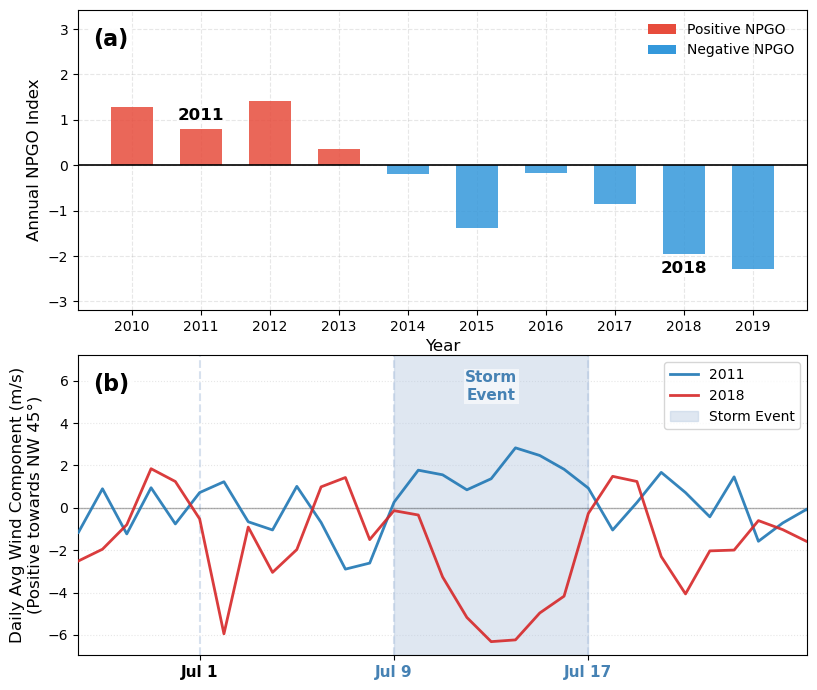

In [9]:
# Time Selection - Annual NPGO and Storm Wind Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import netCDF4 as nc
import datetime
import os

# ================= 配置区域 =================
# --- 图 a: NPGO ---
FILE_NPGO = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Data_NPGO/npgo.csv'

# --- 图 b: Storm Wind Analysis ---
TARGET_LAT = 49.0
TARGET_LON = -123.25 
TARGET_LON_ADJUSTED = 360 + TARGET_LON 
GRID_BOX_RADIUS = 10 
PROJECTION_ANGLE_DEG = 315.0 
MONTHS = [6, 7, 8, 9] 
YEARS = [2011, 2018]

indir_data = {
    2011: '/results/forcing/atmospheric/GEM2.5/gemlam/',
    2018: '/results/forcing/atmospheric/GEM2.5/operational/',
}
fname_head = {
    2011: 'gemlam_',
    2018: 'ops_',
}
fname_tail = '.nc'

indir_results = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_pdf/'
if not os.path.exists(indir_results):
    os.makedirs(indir_results)

subregion_cache = {}
# ==================================================

# ----------------- 数据处理函数 (图 a) -----------------
def get_annual_npgo():
    try:
        # 读取 NPGO 数据
        df = pd.read_csv(FILE_NPGO, skiprows=1, names=['Date', 'NPGO'], skipinitialspace=True)
        df['Date'] = pd.to_datetime(df['Date'])
        df['NPGO'] = pd.to_numeric(df['NPGO'], errors='coerce')
        df.loc[df['NPGO'] == -9999, 'NPGO'] = None
        df.dropna(inplace=True)
        
        # 计算全年平均
        df['Year'] = df['Date'].dt.year
        annual_npgo = df.groupby('Year')['NPGO'].mean()
        
        # 取 2010 - 2019 年的数据以适配图表
        annual_npgo = annual_npgo[(annual_npgo.index >= 2010) & (annual_npgo.index <= 2019)]
        return annual_npgo
    except Exception as e:
        print(f"Error reading NPGO: {e}")
        return None

# ----------------- 数据处理函数 (图 b) -----------------
def find_grid_index(nc_file_path, lat_t, lon_t, radius):
    try:
        with nc.Dataset(nc_file_path, 'r') as ds:
            if 'nav_lat' in ds.variables:
                lats = ds.variables['nav_lat'][:]
                lons = ds.variables['nav_lon'][:]
            elif 'latitude' in ds.variables:
                lats = ds.variables['latitude'][:]
                lons = ds.variables['longitude'][:]
            else:
                return None, None, None, None

        sq_dist = (lons - lon_t)**2 + (lats - lat_t)**2
        j_target, i_target = np.unravel_index(sq_dist.argmin(), sq_dist.shape)
        
        j_start = max(0, j_target - radius)
        j_end = min(lats.shape[0], j_target + radius + 1)
        i_start = max(0, i_target - radius)
        i_end = min(lats.shape[1], i_target + radius + 1)
        return j_start, j_end, i_start, i_end
    except:
        return None, None, None, None

def get_daily_projected_wind(year, month_list, lat_t, lon_t, radius, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    sin_a = np.sin(angle_rad)
    cos_a = np.cos(angle_rad)
    
    days_axis = []
    daily_values = []
    
    path = indir_data[year]
    head = fname_head[year]
    
    sample_file = path + head + datetime.date(year, 6, 1).strftime('y%Ym%md%d') + fname_tail
    cache_key = (year, lat_t, lon_t)
    
    if cache_key in subregion_cache:
        j_s, j_e, i_s, i_e = subregion_cache[cache_key]
    else:
        if not os.path.exists(sample_file):
             sample_file = path + head + datetime.date(year, 6, 2).strftime('y%Ym%md%d') + fname_tail
        if os.path.exists(sample_file):
            j_s, j_e, i_s, i_e = find_grid_index(sample_file, lat_t, lon_t, radius)
            subregion_cache[cache_key] = (j_s, j_e, i_s, i_e)
        else:
            return [], []

    start_date = datetime.date(year, month_list[0], 1)
    end_date = datetime.date(year, month_list[-1], 30)
    current_date = start_date
    day_counter = 0 
    
    print(f"Processing {year}...")
    while current_date <= end_date:
        fpath = path + head + current_date.strftime('y%Ym%md%d') + fname_tail
        val_to_append = np.nan
        if os.path.exists(fpath) and j_s is not None:
            try:
                with nc.Dataset(fpath, 'r') as ds:
                    u_data = ds.variables['u_wind'][:, j_s:j_e, i_s:i_e]
                    v_data = ds.variables['v_wind'][:, j_s:j_e, i_s:i_e]
                    u_spatial = np.mean(u_data, axis=(1, 2))
                    v_spatial = np.mean(v_data, axis=(1, 2))
                    wind_proj = (u_spatial * sin_a) + (v_spatial * cos_a)
                    val_to_append = np.mean(wind_proj)
            except: pass
        
        days_axis.append(day_counter)
        daily_values.append(val_to_append)
        current_date += datetime.timedelta(days=1)
        day_counter += 1
        
    return days_axis, daily_values

# ----------------- 主程序及合并绘图 -----------------
def main():
    print("--- Fetching Data ---")
    # 获取图 a 数据 (仅 NPGO)
    npgo_series = get_annual_npgo()
    
    # 获取图 b 数据
    data_storage = {}
    for yr in YEARS:
        days, values = get_daily_projected_wind(
            yr, MONTHS, TARGET_LAT, TARGET_LON_ADJUSTED, 
            GRID_BOX_RADIUS, PROJECTION_ANGLE_DEG
        )
        data_storage[yr] = (days, values)

    print("--- Plotting ---")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.27, 7))

    # ==========================================
    # 绘制图 (a): Annual NPGO Index
    # ==========================================
    if npgo_series is not None:
        years = npgo_series.index
        # NPGO 正相用红色，负相用蓝色 (气候学标准配色)
        colors = ['#E74C3C' if val >= 0 else '#3498DB' for val in npgo_series.values]
        
        ax1.bar(years, npgo_series.values, color=colors, alpha=0.85, width=0.6, zorder=2)
        ax1.axhline(0, color='black', linewidth=1.2, zorder=3)
        
        # 着重标注 2011 和 2018 年
        for target_year in YEARS:
            if target_year in years:
                val = npgo_series[target_year]
                offset = 0.15 if val >= 0 else -0.15
                align = 'bottom' if val >= 0 else 'top'
                
                # 画个星星在柱子顶端
                # ax1.plot(target_year, val + offset/2, marker='*', color='#F1C40F', 
                #          markeredgecolor='black', markersize=14, zorder=5)
                # 加上年份文字标签
                ax1.text(target_year, val + offset, f'{target_year}', ha='center', va=align,
                         fontsize=12, fontweight='bold', color='black',
                         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5), zorder=5)

        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylabel('Annual NPGO Index', fontsize=12)
        
        # 图例说明
        legend_elements = [
            Patch(facecolor='#E74C3C', label='Positive NPGO'),
            Patch(facecolor='#3498DB', label='Negative NPGO'),
            # plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='#F1C40F', 
            #            markeredgecolor='black', markersize=12, label='Target Years')
        ]
        ax1.legend(handles=legend_elements, loc='upper right', frameon=False)

        ax1.grid(True, linestyle='--', alpha=0.3, zorder=0) 
        ax1.set_axisbelow(True)      
        
        # 适当拉高 Y 轴，给文字标签留出空间
        y_max = npgo_series.abs().max()
        ax1.set_ylim(-y_max * 1.4, y_max * 1.5)
        ax1.set_xticks(years)

    ax1.text(0.02, 0.94, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'), zorder=20)

    # ==========================================
    # 绘制图 (b): Storm Wind Analysis (无变化)
    # ==========================================
    colors_line = {2011: 'tab:blue', 2018: 'tab:red'}
    color_storm = 'lightsteelblue'
    
    for year in YEARS:
        days, values = data_storage[year]
        ax2.plot(days, values, label=f'{year}', color=colors_line[year], linewidth=2, alpha=0.9, zorder=3)

    storm_start, storm_end = 38, 46
    ax2.axvspan(storm_start, storm_end, color=color_storm, alpha=0.4, label='Storm Event', zorder=1)
    
    y_limits = ax2.get_ylim()
    text_y = y_limits[1] - (y_limits[1] - y_limits[0]) * 0.05 
    ax2.text((storm_start + storm_end)/2, text_y, 'Storm\nEvent', ha='center', va='top', fontsize=11, 
             fontweight='bold', color='steelblue', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1), zorder=4)
    
    major_ticks = [30, 38, 46] 
    major_labels = ['Jul 1', 'Jul 9', 'Jul 17']
    ax2.set_xticks(major_ticks)
    ax2.set_xticklabels(major_labels, rotation=0, fontsize=11, fontweight='bold')
    
    for label in ax2.get_xticklabels():
        if label.get_text() in ['Jul 9', 'Jul 17']:
            label.set_color('steelblue')
        elif label.get_text() == 'Jul 1':
            label.set_color('black')    

    ax2.set_xlim(25, 55)
    
    ax2.grid(True, which='major', axis='x', linestyle='--', color=color_storm, linewidth=1.5, alpha=0.5, zorder=0)
    ax2.grid(True, axis='y', linestyle=':', alpha=0.3, zorder=0)
    ax2.set_axisbelow(True)
    
    ax2.axhline(0, color='black', linewidth=1, alpha=0.3, zorder=2)
    
    ax2.set_ylabel('Daily Avg Wind Component (m/s)\n(Positive towards NW 45°)', fontsize=12)
    ax2.legend(loc='upper right', frameon=True) 
    
    ax2.text(0.02, 0.94, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'), zorder=20)

    # ==========================================
    # 最终排版与保存
    # ==========================================
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.15) 
    
    save_path = os.path.join(indir_results, 'Time_Period.pdf')
    plt.savefig(save_path, dpi=300, format='pdf', bbox_inches='tight')
    print(f"Plot saved to: {save_path}")
    plt.show()

if __name__ == "__main__":
    main()

### PCA and Analysis

#### Data

To investigate the spatiotemporal variability of Sea Surface Salinity (SSS) in the Strait of Georgia during the summer months (June to September) from 2010 to 2019, multiple long-term datasets were synthesized:

* **Sea Surface Salinity:** Daily SSS fields were obtained from [在此处填入数据源，如 SalishSeaCast model / 卫星数据 / 观测插值数据] with a spatial resolution of [填入分辨率].
* **River Discharge:** Daily Fraser River discharge data () were utilized to represent the primary freshwater forcing in the system.
* **Wind Data:** Daily meteorological records were acquired from the Environment Canada Sand Heads station. To isolate the wind component driving the main hydrodynamics along the strait , the daily maximum gust speed and direction were projected onto the principal axis of the Strait of Georgia (135°/315°). The along-strait wind velocity was calculated as:

where  is the magnitude of the maximum wind gust, and  is the wind direction (originating from). In this convention, positive values represent winds blowing from the southeast (SE, 135°), typically associated with downwelling or inflow conditions, while negative values indicate winds from the northwest (NW, 315°), favoring upwelling or outflow conditions.

#### Principal Component Analysis (PCA)

To extract the dominant modes of SSS variability, an Empirical Orthogonal Function (EOF) analysis, also known as PCA, was performed on the 10-year summer SSS dataset. Prior to the PCA, the spatial mean and long-term trends were removed to yield SSS anomalies. The analysis decomposed the complex multidimensional SSS fields into a set of orthogonal spatial patterns (EOF modes) and their corresponding time-varying amplitudes (Principal Components, PCs). The first three modes were retained for detailed physical interpretation.

#### Statistical and Spectral Analyses

To determine the distinct physical drivers corresponding to the first three SSS modes, the respective PCs were analyzed against environmental forcings:

* **Mode 1 (Riverine Influence):** A linear regression and Pearson correlation analysis were conducted between the amplitude of PC 1 and the Fraser River discharge to evaluate the direct freshwater plume effect.
* **Mode 2 (Wind-Driven Response):** To assess the delayed response of the SSS field to wind forcing, a Cross-Correlation Function (CCF) was applied between the along-strait wind velocity and PC 2. The Pearson correlation coefficient was calculated for time lags ranging from -15 to +15 days, allowing for the identification of the optimal response time (e.g., a 1-day lag) and its statistical significance (evaluated at the 95% confidence level).
* **Mode 3 (Tidal Periodicity):** A spectral analysis was performed on PC 3 to detect high-frequency cyclical signals, such as tidal modulations. The daily time series for each summer season was linearly detrended, and the spectral power density was estimated using the periodogram method. To ensure robustness, the resulting periodograms from the 10 individual years were averaged. The final mean spectrum was examined for characteristic peaks, specifically the 14.8-day spring-neap tidal cycle.


### Wind Speed Process: Extraction of Along-Strait Wind Components


To accurately assess the wind forcing along the principal axis of the Strait of Georgia, wind vectors were projected onto the northwest-southeast (NW-SE) axis. For the long-term climatological analysis (2010–2019), daily maximum gust speed and direction data were obtained from the coastal station. The wind speeds were converted from km/h to m/s, and the along-strait wind magnitude was calculated by taking the absolute value of the cosine projection of the observed wind direction relative to the principal axis.

For the daily scale storm analysis in 2011 and 2018, high-resolution atmospheric model data (GEM2.5) were utilized. The eastward (U) and northward (V) wind velocity components were spatially averaged over a grid box (radius = 10 grid points) centered at the target location (49.0°N, 123.25°W). These spatially averaged components were then mathematically projected onto the NW 45° vector to yield the daily average along-strait wind component. In this projection, positive values denote wind forcing directed towards the northwest (NW 45°), effectively capturing the wind dynamics most relevant to the local marine environment.

### Case Study Selection

To investigate the biological response to along-strait wind forcing, the years 2011 and 2018 were selected as contrasting case studies. Based on our long-term climatological analysis, these two years represent opposite extremes in summer wind speed anomalies and regional climatic conditions. Furthermore, to isolate and examine the short-term ecological impacts of wind events, we narrowed our comparative analysis to a specific timeframe from July 9 to July 17. During this window, distinct storm events occurred in both years but with opposing wind directions along the NW 45° axis. This contrasting scenario provides an ideal natural experiment to evaluate how opposite wind-forcing mechanisms influence the local marine environment.


## SSS PCA (Results Part 1)

Loading datasets...


/tmp/ipykernel_929424/970890582.py:263: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(OUTPUT_PDF, format='pdf', dpi=300, bbox_inches='tight')


✅ 合并绘图已成功保存为: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_pdf/Figure_PCA_Comprehensive.pdf


/home/jqiu/conda_envs/analysis-junqi/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


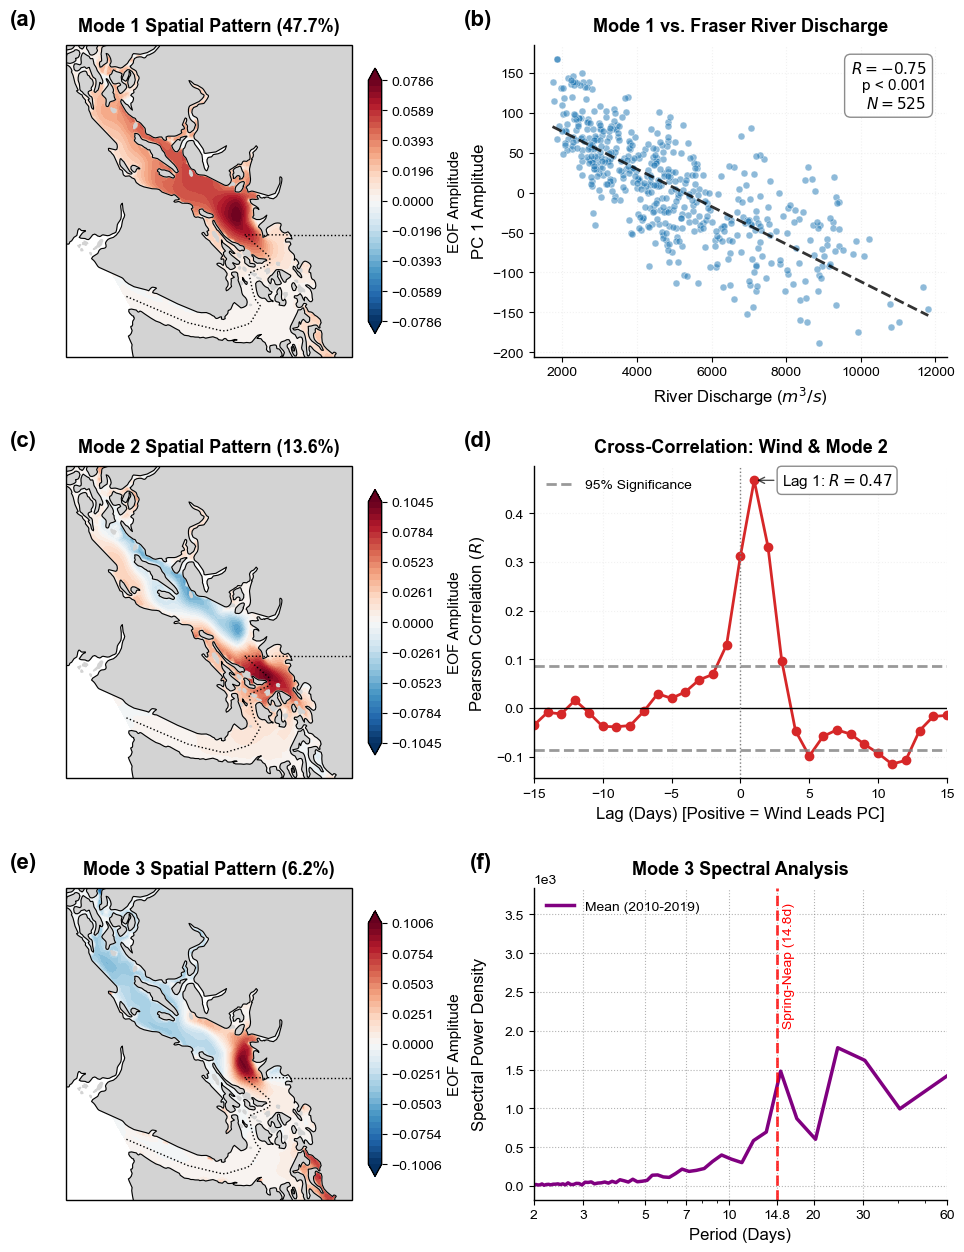

In [26]:
# PCA & Analysis

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats, signal

# ==================== 0. 全局设置 (发表级 PDF 设置) ====================
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

# ==================== 1. 路径与配置 ====================
DIR_RESULTS = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA_10yr/'
DIR_DATA    = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Data_PCs/'
DIR_PDF = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_pdf/'

NPY_PATH  = os.path.join(DIR_RESULTS, 'PCA_Decade_Spatial_Data.npz')
PATH_PC   = os.path.join(DIR_DATA, 'PCA_Decade_TimeSeries_2010_2019.csv')
PATH_FLOW = os.path.join(DIR_DATA, 'Fraser_flow')
PATH_WIND = os.path.join(DIR_DATA, 'Summer_Daily_AlongStrait_Wind_2010-2019.csv')

SUMMER_MONTHS = [6, 7, 8, 9]
START_YEAR = 2010
END_YEAR = 2019
OUTPUT_PDF = os.path.join(DIR_PDF, 'Figure_PCA_Comprehensive.pdf')

# ==================== 2. 数据读取与预处理 ====================
def load_all_data():
    print("Loading datasets...")
    spatial_data = dict(np.load(NPY_PATH, allow_pickle=True))
    
    df_pcs = pd.read_csv(PATH_PC)
    df_pcs.columns = df_pcs.columns.str.strip()
    df_pcs['Date'] = pd.to_datetime(df_pcs['Date'])
    df_pcs.set_index('Date', inplace=True)
    df_pcs.sort_index(inplace=True)
    
    df_flow = pd.read_csv(PATH_FLOW, sep=r'\s+', header=None, names=['Year', 'Month', 'Day', 'Flow'], comment='#')
    df_flow['Date'] = pd.to_datetime(df_flow[['Year', 'Month', 'Day']])
    df_flow.set_index('Date', inplace=True)
    
    df_wind = pd.read_csv(PATH_WIND)
    date_col = 'Date/Time' if 'Date/Time' in df_wind.columns else 'Date'
    df_wind['Date'] = pd.to_datetime(df_wind[date_col])
    df_wind.set_index('Date', inplace=True)
    
    # 合并夏季数据
    df_merged = df_pcs.join(df_wind[['Along_Strait_Wind']], how='inner').join(df_flow[['Flow']], how='inner')
    df_summer = df_merged[df_merged.index.month.isin(SUMMER_MONTHS)].copy()
    
    return spatial_data, df_pcs, df_summer

# ==================== 3. 子图绘制函数 ====================

def plot_spatial_mode(ax, mode_idx, spatial_data):
    """左侧：绘制空间模态图"""
    eofs = spatial_data['eofs']
    mask = spatial_data['mask']
    grid_shape = spatial_data['shape']
    var_ratio = spatial_data['variance']
    
    eof_1d = eofs[mode_idx]
    full_field = np.full(mask.shape, np.nan)
    full_field[mask] = eof_1d
    eof_2d = full_field.reshape(grid_shape)
    
    ax.set_extent([-125.5, -122, 48, 50.5], crs=ccrs.PlateCarree())
    
    limit = np.nanmax(np.abs(eof_2d))
    levels = np.linspace(-limit, limit, 41)
    
    cf = ax.contourf(spatial_data['lon'], spatial_data['lat'], eof_2d, 
                     levels=levels, cmap='RdBu_r', transform=ccrs.PlateCarree(), extend='both')
    
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=2)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=3)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=3)
    
    cbar = plt.colorbar(cf, ax=ax, shrink=0.85, pad=0.04)
    cbar.set_label('EOF Amplitude', fontsize=11)
    cbar.ax.tick_params(labelsize=10)
    
    title = f"Mode {mode_idx+1} Spatial Pattern ({var_ratio[mode_idx]*100:.1f}%)"
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)

def plot_scatter(ax, x, y, title, xlabel, ylabel, color):
    """右侧 1：散点图"""
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]
    
    ax.scatter(x_clean, y_clean, color=color, alpha=0.5, s=25, edgecolors='white', linewidth=0.5)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
    x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, color='k', linestyle='--', linewidth=2, alpha=0.8)
    
    loc_x, loc_y, ha = (0.95, 0.95, 'right') if r_value < 0 else (0.05, 0.95, 'left')
    p_text = 'p < 0.001' if p_value < 0.001 else f'p = {p_value:.3f}'
    stats_text = f'$R = {r_value:.2f}$\n{p_text}\n$N = {len(x_clean)}$'
    
    ax.text(loc_x, loc_y, stats_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment=ha,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9, edgecolor='gray'))

    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.5)

def plot_cross_correlation(ax, s_driver, s_response, title, color, max_lag=15):
    """右侧 2：延迟相关折线图 (CCF)"""
    lags = np.arange(-max_lag, max_lag + 1)
    corrs = []
    
    # 对齐数据去 NaN
    df_temp = pd.concat([s_driver, s_response], axis=1).dropna()
    col_driver, col_response = df_temp.columns
    
    for lag in lags:
        # 当 lag > 0 时，driver.shift(lag) 意味着风场比 PC 提前 lag 天
        driver_shifted = df_temp[col_driver].shift(lag)
        valid = ~driver_shifted.isna() & ~df_temp[col_response].isna()
        
        if valid.sum() > 30: # 保证有效数据点足够
            r, _ = stats.pearsonr(driver_shifted[valid], df_temp[col_response][valid])
            corrs.append(r)
        else:
            corrs.append(np.nan)
            
    # 画折线和数据点
    ax.plot(lags, corrs, marker='o', markersize=6, color=color, linestyle='-', linewidth=2)
    # === 新增：寻找 lag = 1 的相关系数并标注 ===
    idx_lag1 = np.where(lags == 1)[0][0]
    r_lag1 = corrs[idx_lag1]
    
    # 标注框：使用 annotate 生成一个指向 lag=1 点的小箭头
    ax.annotate(f'Lag 1: $R = {r_lag1:.2f}$', 
                xy=(1, r_lag1),            # 箭头指向的数据点位置
                xytext=(3, r_lag1),        # 文本框的中心位置 (往右平移)
                arrowprops=dict(facecolor='black', arrowstyle='->', alpha=0.7),
                fontsize=11, 
                verticalalignment='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # 画 0 准线
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.axvline(0, color='gray', linestyle=':', linewidth=1)
    
    # 画 95% 置信区间粗略估计线 (±1.96 / sqrt(N))
    N_eff = len(df_temp)
    conf_int = 1.96 / np.sqrt(N_eff)
    ax.axhline(conf_int, color='gray', linestyle='--', alpha=0.8, label='95% Significance')
    ax.axhline(-conf_int, color='gray', linestyle='--', alpha=0.8)
    
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Lag (Days) [Positive = Wind Leads PC]', fontsize=12)
    ax.set_ylabel('Pearson Correlation ($R$)', fontsize=12)
    ax.set_xlim(-max_lag, max_lag)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend(loc='upper left', fontsize=10)

def plot_spectrum(ax, df_pcs):
    """右侧 3：频谱分析图"""
    power_list = []
    frequencies = None
    
    for year in range(START_YEAR, END_YEAR + 1):
        start_date, end_date = f"{year}-06-01", f"{year}-09-30"
        summer_series = df_pcs.loc[start_date:end_date, 'PC_3']
        
        if len(summer_series) < 10:
            continue
            
        perfect_idx = pd.date_range(start_date, end_date, freq='D')
        summer_series = summer_series.reindex(perfect_idx).interpolate(method='linear').bfill().ffill()
        
        data_detrended = signal.detrend(summer_series.values)
        f, Pxx = signal.periodogram(data_detrended, fs=1.0)
        
        power_list.append(Pxx)
        if frequencies is None: frequencies = f

    power_matrix = np.array(power_list)
    avg_power = np.mean(power_matrix, axis=0)

    valid_mask = frequencies > 0
    periods = 1.0 / frequencies[valid_mask]
    avg_power_plot = avg_power[valid_mask]

    ax.plot(periods, avg_power_plot, color='purple', linewidth=2.5, label=f'Mean ({START_YEAR}-{END_YEAR})')
    
    ax.set_xscale('log')
    ax.set_xlim(2, 60) 
    
    custom_ticks = [2, 3, 5, 7, 10, 14.8, 20, 30, 60]
    ax.set_xticks(custom_ticks)
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.set_xticklabels([str(t) for t in custom_ticks])

    ax.axvline(14.8, color='red', linestyle='--', linewidth=2, alpha=0.8)
    ax.text(15.5, ax.get_ylim()[1]*0.95, 'Spring-Neap (14.8d)', 
            color='red', rotation=90, verticalalignment='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.8))

    ax.set_xlabel('Period (Days)', fontsize=12)
    ax.set_ylabel('Spectral Power Density', fontsize=12)
    ax.set_title('Mode 3 Spectral Analysis', fontsize=13, fontweight='bold', pad=10)
    ax.grid(True, which="major", ls=":", alpha=0.6, color='gray')
    ax.legend(loc='upper left', fontsize=10)
    # 强制 Y 轴使用科学记数法
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# ==================== 4. 主干逻辑 ====================
def main():
    spatial_data, df_pcs, df_summer = load_all_data()
    
    fig = plt.figure(figsize=(12, 15))
    gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], wspace=0.25, hspace=0.35)
    
    # --- Row 1: Mode 1 ---
    ax_map1 = fig.add_subplot(gs[0, 0], projection=ccrs.Mercator(central_longitude=-124))
    plot_spatial_mode(ax_map1, 0, spatial_data)
    
    ax_scat1 = fig.add_subplot(gs[0, 1])
    plot_scatter(ax_scat1, df_summer['Flow'], df_summer['PC_1'], 
                 'Mode 1 vs. Fraser River Discharge', 'River Discharge ($m^3/s$)', 'PC 1 Amplitude', '#1f77b4')

    # --- Row 2: Mode 2 (Changed to CCF) ---
    ax_map2 = fig.add_subplot(gs[1, 0], projection=ccrs.Mercator(central_longitude=-124))
    plot_spatial_mode(ax_map2, 1, spatial_data)
    
    ax_ccf2 = fig.add_subplot(gs[1, 1])
    # 这里计算风场和PC_2的延迟相关。最大延迟设为前后 15 天
    plot_cross_correlation(ax_ccf2, df_summer['Along_Strait_Wind'], df_summer['PC_2'], 
                           'Cross-Correlation: Wind & Mode 2', color='#d62728', max_lag=15)

    # --- Row 3: Mode 3 ---
    ax_map3 = fig.add_subplot(gs[2, 0], projection=ccrs.Mercator(central_longitude=-124))
    plot_spatial_mode(ax_map3, 2, spatial_data)
    
    ax_spec3 = fig.add_subplot(gs[2, 1])
    plot_spectrum(ax_spec3, df_pcs)

    # --- 添加论文标签 ---
    axes_list = [ax_map1, ax_scat1, ax_map2, ax_ccf2, ax_map3, ax_spec3]
    labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
    for ax, label in zip(axes_list, labels):
        ax.text(-0.1, 1.05, label, transform=ax.transAxes, 
                fontsize=16, fontweight='bold', va='bottom', ha='right')

    # 强制右侧一列的 Y 轴 Label 垂直对齐
    fig.align_ylabels([ax_scat1, ax_ccf2, ax_spec3])

    plt.savefig(OUTPUT_PDF, format='pdf', dpi=300, bbox_inches='tight')
    print(f"✅ 合并绘图已成功保存为: {OUTPUT_PDF}")

if __name__ == "__main__":
    main()


Figure X. Principal Component Analysis (PCA) of summer (June–September) Sea Surface Salinity (SSS) in the Strait of Georgia from 2010 to 2019 and the corresponding environmental driver analyses. (a, c, e) Spatial patterns of Empirical Orthogonal Function (EOF) Modes 1, 2, and 3. The percentage of total variance explained by each mode is indicated in the panel titles. (b) Scatter plot demonstrating the relationship between the Fraser River discharge and the Principal Component (PC) 1 amplitude. The black dashed line indicates the linear regression fit (R=−0.75, p<0.001). (d) Cross-correlation function between the along-strait wind velocity and PC 2 amplitude. Positive lags indicate that the wind forcing leads the SSS response, with the peak correlation occurring at a 1-day lag (R=0.47). Grey dashed lines represent the 95% confidence bounds. (f) Mean spectral power density of the PC 3 time series averaged over the 10-year study period. The red dashed line highlights a prominent peak near the 14.8-day spring-neap tidal cycle.



### Results

**Dominant Modes of SSS Variability**
The Empirical Orthogonal Function (EOF) analysis decomposed the 10-year summer Sea Surface Salinity (SSS) variability in the Strait of Georgia into several distinct modes. The first three leading modes collectively explain 67.5% of the total variance, capturing the primary responses to riverine forcing, wind-driven dynamics, and tidal modulations.

**Mode 1: Riverine Freshwater Influence**
Mode 1 accounts for the largest share of the variance (47.7%). Its spatial pattern (Figure Xa) is characterized by a strong, positive EOF amplitude centered over the Fraser River estuary and extending outward into the main plume region. The corresponding temporal amplitude, PC 1, exhibits a highly significant negative correlation with the Fraser River discharge (*R* = -0.75, *p* < 0.001; Figure Xb). Physically, an increase in river discharge drives PC 1 toward more negative values. When multiplied by the positive EOF spatial weights in the estuary, this results in a widespread negative SSS anomaly. This confirms that Mode 1 represents the direct freshening effect of the Fraser River plume expanding into the strait during the summer freshet.

**Mode 2: Wind-Driven Ekman Dynamics**
Mode 2 explains 13.6% of the SSS variance and represents the wind-driven response of the surface salinity field. The spatial pattern (Figure Xc) exhibits a distinct lateral (cross-strait) dipole in the central and northern Strait of Georgia, with positive EOF amplitudes along the western boundary (Vancouver Island) and negative amplitudes along the eastern boundary (mainland). Cross-correlation analysis (Figure Xd) reveals that the PC 2 amplitude responds most strongly to the along-strait wind with a 1-day lag (*R* = 0.47, significant at the 95% confidence level).

This lateral salinity structure is highly consistent with classic Ekman dynamics. Positive wind anomalies (southeasterly winds) drive a northward surface flow, which the Coriolis force deflects to the right (eastward). This Ekman transport induces the upwelling of deeper, more saline water along the western shore (increasing SSS) and the downwelling of fresher surface water along the eastern shore (decreasing SSS). While a strong, localized positive SSS anomaly is also observed near the Fraser River estuary—likely linked to wind-induced vertical mixing or the local modulation of the plume structure—the primary signal of Mode 2 captures the broader, wind-driven lateral upwelling and downwelling dynamics within the strait. The complex, near-field interactions between wind forcing and plume hydrodynamics in the estuary region warrant further investigation in future studies.

**Mode 3: Spring-Neap Tidal Modulation**
Mode 3 accounts for 6.2% of the total variance. To investigate the temporal periodicity of this mode, a spectral analysis was performed on the PC 3 time series. The mean spectral power density, averaged over the 10-year study period (Figure Xf), reveals a distinct and prominent high-frequency peak at a period of 14.8 days. This periodicity corresponds directly to the spring-neap tidal cycle. The spatial pattern of Mode 3 (Figure Xe) highlights regions sensitive to tidal mixing. In these areas, the fortnightly modulation of tidal currents periodically mixes deeper, saltier water into the surface layer, thereby driving regular, cyclical variations in the local SSS.



## Case Study (Results Part 2)

### Interannual Climate Variability and Storm Events

Analysis of the long-term historical data (2010–2019) revealed a strong positive correlation (r = 0.672) between the negated North Pacific Gyre Oscillation (-NPGO) index and summer along-strait wind speed anomalies (Figure Xa). Under this broader climatic context, 2011 and 2018 emerged as highly anomalous years exhibiting opposite trends: 2011 was characterized by a negative wind anomaly and a corresponding negative -NPGO phase, whereas 2018 showed a strong positive anomaly. Zooming into the daily scale during the summer of these two years (Figure Xb), two significant and opposing storm events were identified between July 9 and July 17. The 2011 event was dominated by positive wind components (towards NW 45°), while the 2018 event was characterized by strong negative wind components.


Loading data from extracted_biomass_data.pkl...
Generating combined A4 plot...
Saved combined plot: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_Bio/Storm_Focus_Plots/StormFocus_Combined_A4.pdf
Done.


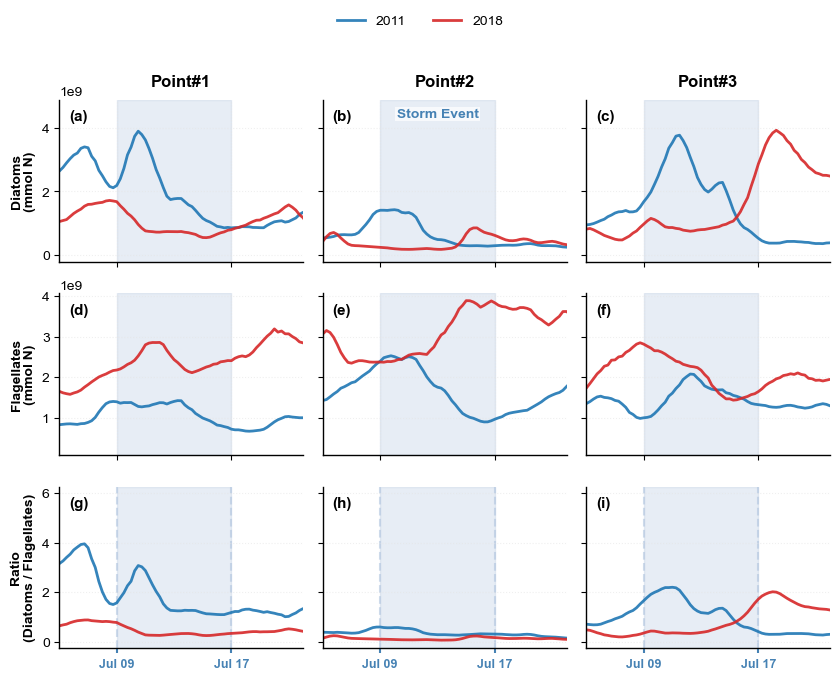

In [ ]:
# During Storm Plot (Combined 3x3 for A4 Report)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pickle
import os
import datetime
import string

# ================= 配置 =================
INPUT_DIR = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_Bio/'
DATA_FILENAME = 'extracted_biomass_data.pkl'
OUTPUT_DIR = os.path.join(INPUT_DIR, 'Storm_Focus_Plots') 

BASE_YEAR = 2011
STORM_START_MD = (7, 9)   
STORM_END_MD = (7, 17)    

PLOT_X_LIM_START = datetime.datetime(BASE_YEAR, 7, 5)
PLOT_X_LIM_END = datetime.datetime(BASE_YEAR, 7, 22)

# 滑动平均窗口大小 (6h * 4 = 24h)
SMOOTH_WINDOW = 4  

# ================= 辅助函数 =================
def smooth_series(data_array, window=SMOOTH_WINDOW):
    """使用 pandas 进行居中滑动平均，消除昼夜锯齿"""
    return pd.Series(data_array).rolling(window=window, center=True, min_periods=1).mean().values

# ================= 绘图核心函数 =================
def plot_all_regions_combined(all_results, save_dir):
    region_keys = list(all_results.keys())[:3]
    
    # 【核心修改】加入 sharey='row'，强制同一行共享 Y 轴量程
    fig, axes = plt.subplots(3, 3, figsize=(8.5, 6.5), sharex=True, sharey='row')
    
    color_2011 = 'tab:blue'
    color_2018 = 'tab:red'
    color_storm_area = 'lightsteelblue' 
    
    vars_config = [
        ('diatoms', 'Diatoms\n(mmol N)'),
        ('flagellates', 'Flagellates\n(mmol N)'),
        ('ratio', 'Ratio\n(Diatoms / Flagellates)')
    ]
    
    t_storm_start = datetime.datetime(BASE_YEAR, *STORM_START_MD)
    t_storm_end = datetime.datetime(BASE_YEAR, *STORM_END_MD)
    alphabet = list(string.ascii_lowercase)

    for col, r_key in enumerate(region_keys):
        region_data = all_results[r_key]
        r_label = region_data['meta']['label']
        years_data = region_data['data']
        
        # 区域标题
        axes[0, col].set_title(r_label, fontsize=12, fontweight='bold', pad=10)
        
        for row, (var_name, y_label) in enumerate(vars_config):
            ax = axes[row, col]
            
            for year in [2011, 2018]:
                if year not in years_data: continue
                yd = years_data[year]
                
                times = yd['times']
                fake_times = [t.replace(year=BASE_YEAR) for t in times]
                c = color_2011 if year == 2011 else color_2018
                
                smoothed_vals = smooth_series(yd[var_name])
                ax.plot(fake_times, smoothed_vals, label=f'{year}', color=c, linewidth=2, alpha=0.9)

            ax.axvspan(t_storm_start, t_storm_end, color=color_storm_area, alpha=0.3, zorder=0)
            ax.grid(True, linestyle=':', alpha=0.6)
            
            # (a) (b) (c) 标注
            plot_idx = row * 3 + col 
            ax.text(0.04, 0.94, f'({alphabet[plot_idx]})', transform=ax.transAxes, 
                    fontsize=11, fontweight='bold', va='top', ha='left',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1.5))

            # Y轴标签只在第一列显示
            if col == 0:
                ax.set_ylabel(y_label, fontsize=10, fontweight='bold')
            
            # 【核心修改】将 Storm Event 文字放在第一行、中间列的图里 (Point#2)
            if row == 0 and col == 1:
                mid_storm = t_storm_start + (t_storm_end - t_storm_start)/2
                # 使用 get_xaxis_transform 使得 Y 轴坐标为 0-1 的相对比例，X 轴为实际时间
                # 这样即使共享 Y 轴导致量程变化，文字也能稳稳停在顶部 95% 的位置
                ax.text(mid_storm, 0.95, 'Storm Event', 
                        transform=ax.get_xaxis_transform(),
                        ha='center', va='top', color='steelblue', 
                        fontweight='bold', fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

            # X轴定制
            if row == 2:
                ax.set_xlim(PLOT_X_LIM_START, PLOT_X_LIM_END)
                ax.set_xticks([t_storm_start, t_storm_end])
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
                
                ax.tick_params(axis='x', colors='steelblue', width=1.5, labelsize=9)
                for label_obj in ax.get_xticklabels():
                    label_obj.set_fontweight('bold')
                    
                ax.grid(True, which='major', axis='x', linestyle='--', linewidth=1.5, color=color_storm_area)

    # 全局图例
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=2, fontsize=10, frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90) 
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # 导出为 PDF
    out_name = 'StormFocus_Combined_A4.pdf'
    save_path = os.path.join(save_dir, out_name)
    plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
    # plt.close()
    print(f"Saved combined plot: {save_path}")


# ================= 主程序 =================
if __name__ == "__main__":
    pkl_path = os.path.join(INPUT_DIR, DATA_FILENAME)
    
    if not os.path.exists(pkl_path):
        print(f"Error: Data file not found: {pkl_path}")
        exit()
        
    print(f"Loading data from {DATA_FILENAME}...")
    with open(pkl_path, 'rb') as f:
        all_results = pickle.load(f)
        
    print("Generating combined A4 plot...")
    plot_all_regions_combined(all_results, OUTPUT_DIR)
        
    print("Done.")

Caption: Time series of depth-integrated (0–20 m) phytoplankton biomass and their composition ratios at three selected stations in the Strait of Georgia during the summer of 2011 (blue lines) and 2018 (red lines). The top, middle, and bottom rows represent the biomass of diatoms (mmol N), flagellates (mmol N), and the diatom-to-flagellate ratio, respectively. The columns from left to right correspond to Point #1 (central channel), Point #2 (western coast), and Point #3 (eastern coast). The light blue shaded area indicates the prolonged storm event spanning from July 9 to July 17. A 24-hour moving average was applied to the 6-hourly model outputs to filter out diurnal cycles. Note that the y-axes are shared across each row for direct spatial comparison.

### Contrasting Spatial Responses to Wind-Driven Upwelling and Downwelling

The biological responses to the storm events exhibited strong spatial heterogeneity, largely modulated by the cross-basin wind direction and the resulting Ekman transport. Station Point #3, located on the eastern coastline, demonstrated a highly sensitive and contrasting response between the two years. During the 2018 storm, the southeastward-blowing wind induced a southwestward Ekman transport, driving coastal upwelling along the eastern shore. This injection of nutrient-rich deep water triggered a massive post-storm diatom bloom (Figure Xc, red line) and a sharp increase in the diatom-to-flagellate ratio (Figure Xi). Conversely, the northwestward wind in 2011 caused water accumulation and downwelling at Point #3, suppressing nutrient renewal and leading to a continuous decline in both diatom biomass (Figure Xc, blue line) and their relative dominance (Figure Xi).

In stark contrast, Point #1 (central channel) and Point #2 (western coast) displayed relatively muted or complex responses to the wind forcing. This can be attributed to their proximity to the Fraser River plume. As suggested by our Principal Component Analysis (PCA), the freshwater discharge from the Fraser River introduces strong local stratification and complex advective dynamics. We hypothesize that this dominant estuarine circulation largely overprints or masks the wind-driven upwelling/downwelling signals at these stations, dampening the purely meteorological-driven biological fluctuations.

### Whole Domain Show

Loading data from whole_domain_july_biomass.pkl...
Generating Whole Domain trends plot...


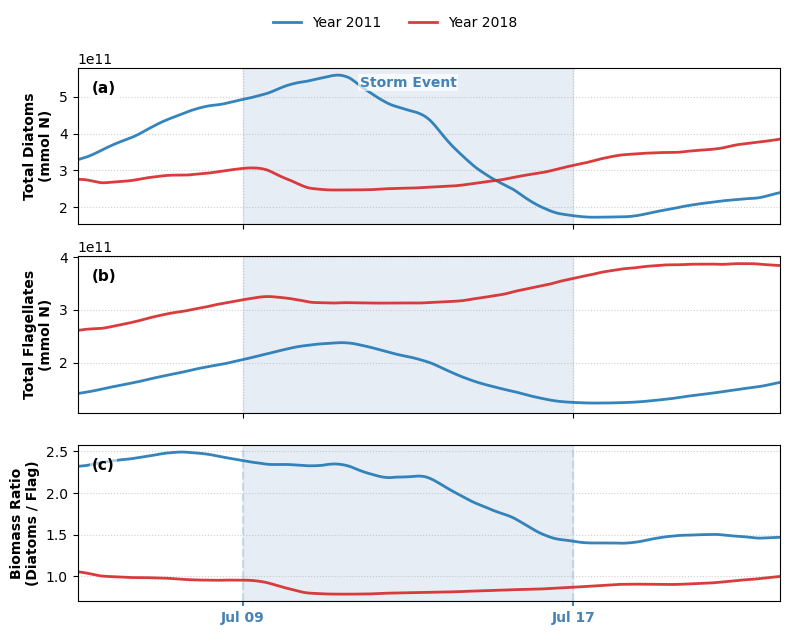

Saved whole domain plot: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_pdf/Whole_Domain_July_Trends.pdf
Done.


In [4]:
# Whole Domain Plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import pickle
import os
import datetime
import string

# ================= 配置 =================
INPUT_DIR = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_Bio/'
# 注意：这里改为刚才算全域时保存的文件名
DATA_FILENAME = 'whole_domain_july_biomass.pkl'
OUTPUT_DIR = os.path.join(INPUT_DIR, 'Whole_Domain_Plots') 

BASE_YEAR = 2011  # 用于对齐 X 轴显示
SMOOTH_WINDOW = 24  # 24小时滑动平均

# 风暴期及 X 轴显示范围配置 (参考了第二个脚本)
STORM_START_MD = (7, 9)   
STORM_END_MD = (7, 17)    
PLOT_X_LIM_START = datetime.datetime(BASE_YEAR, 7, 5)
PLOT_X_LIM_END = datetime.datetime(BASE_YEAR, 7, 22)

# ================= 辅助函数 =================
def smooth_series(data_array, window=SMOOTH_WINDOW):
    """居中滑动平均，消除昼夜锯齿"""
    return pd.Series(data_array).rolling(window=window, center=True, min_periods=1).mean().values

# ================= 绘图核心函数 =================
def plot_whole_domain_trends(results_by_year, save_dir):
    # 创建 3行1列 的画布，调整比例使其更适合 A4 纸插入 (不占整页)
    fig, axes = plt.subplots(3, 1, figsize=(8, 6.5), sharex=True)
    
    color_2011 = 'tab:blue'
    color_2018 = 'tab:red'
    color_storm_area = 'lightsteelblue' 
    
    # 变量配置 (变量名, Y轴标签)
    vars_config = [
        ('diatoms', 'Total Diatoms\n(mmol N)'),
        ('flagellates', 'Total Flagellates\n(mmol N)'),
        ('ratio', 'Biomass Ratio\n(Diatoms / Flag)')
    ]
    
    t_storm_start = datetime.datetime(BASE_YEAR, *STORM_START_MD)
    t_storm_end = datetime.datetime(BASE_YEAR, *STORM_END_MD)
    alphabet = list(string.ascii_lowercase)
    
    for row, (var_name, y_label) in enumerate(vars_config):
        ax = axes[row]
        
        for year in [2011, 2018]:
            if year not in results_by_year:
                continue
            
            data = results_by_year[year]
            times = data['times']
            # 将所有年份对齐到同一虚拟年份，方便重叠对比
            fake_times = [t.replace(year=BASE_YEAR) for t in times]
            
            # 现算 Ratio 或是直接读取
            if var_name == 'ratio':
                vals = np.array(data['diatoms']) / np.array(data['flagellates'])
            else:
                vals = np.array(data[var_name])
            
            # 平滑处理
            smoothed_vals = smooth_series(vals)
            
            c = color_2011 if year == 2011 else color_2018
            ax.plot(fake_times, smoothed_vals, label=f'Year {year}', color=c, linewidth=2, alpha=0.9)

        # 添加风暴期阴影
        ax.axvspan(t_storm_start, t_storm_end, color=color_storm_area, alpha=0.3, zorder=0)
        ax.set_ylabel(y_label, fontsize=10, fontweight='bold')
        ax.grid(True, linestyle=':', alpha=0.6)
        
        # (a) (b) (c) 标注：放在左上角
        ax.text(0.02, 0.92, f'({alphabet[row]})', transform=ax.transAxes, 
                fontsize=11, fontweight='bold', va='top', ha='left',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1.5))

        # 风暴文字只在第一行 (Diatoms) 顶部显示
        if row == 0:
            mid_storm = t_storm_start + (t_storm_end - t_storm_start)/2
            ax.text(mid_storm, 0.95, 'Storm Event', 
                    transform=ax.get_xaxis_transform(),
                    ha='center', va='top', color='steelblue', 
                    fontweight='bold', fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

        # 优化 X 轴显示 (限制范围，只在最后一行设置刻度格式)
        if row == 2:
            ax.set_xlim(PLOT_X_LIM_START, PLOT_X_LIM_END)
            ax.set_xticks([t_storm_start, t_storm_end])
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
            
            ax.tick_params(axis='x', colors='steelblue', width=1.5, labelsize=10)
            for label_obj in ax.get_xticklabels():
                label_obj.set_fontweight('bold')
                
            ax.grid(True, which='major', axis='x', linestyle='--', linewidth=1.5, color=color_storm_area)
            # ax.set_xlabel(f'July Trends (Normalized to {BASE_YEAR})', fontsize=10, fontweight='bold', labelpad=10)

    # 全局标题和图例
    # fig.suptitle('Salish Sea Whole Domain Biomass (Top 20m) - July Comparison', 
    #             fontsize=12, fontweight='bold', y=1.02)
    
    handles, labels = axes[0].get_legend_handles_labels()
    # 图例放在图表外部正上方居中
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
               ncol=2, fontsize=10, frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # 给顶部的标题和图例留出空间
    
    
        
    out_name = 'Whole_Domain_July_Trends.pdf'
    save_path = os.path.join('/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_pdf/', out_name)
    plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved whole domain plot: {save_path}")

# ================= 主程序 =================
if __name__ == "__main__":
    pkl_path = os.path.join(INPUT_DIR, DATA_FILENAME)
    
    if not os.path.exists(pkl_path):
        print(f"Error: Data file not found: {pkl_path}")
        exit()
        
    print(f"Loading data from {DATA_FILENAME}...")
    with open(pkl_path, 'rb') as f:
        results_by_year = pickle.load(f)
        
    print("Generating Whole Domain trends plot...")
    plot_whole_domain_trends(results_by_year, OUTPUT_DIR)
        
    print("Done.")